In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
import json
from tqdm.autonotebook import tqdm
from collections import Counter
import time

from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.evaluation import RankBasedEvaluator
from pykeen import predict

import torch

C:\Users\vijmr\AppData\Local\Temp/ipykernel_17796/373539399.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\Users\vijmr\anaconda3\envs\cv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [6]:
subjects = ['Alice', 'Alice', 'Alice', 'Alice', 'Alice', 'Alice', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Charlie', 'Charlie', 'Charlie', 'Charlie', 'Charlie', 'Charlie', 'David', 'David', 'David', 'David', 'David', 'David', 'Eve', 'Eve', 'Eve', 'Eve', 'Eve', 'Eve']
predicates = ['friend_with', 'friend_with', 'has_hobby', 'has_hobby', 'has_occupation', 'has_occupation', 'friend_with', 'friend_with', 'has_hobby', 'has_hobby', 'has_occupation', 'has_occupation', 'friend_with', 'friend_with', 'has_hobby', 'has_hobby', 'has_occupation', 'has_occupation', 'friend_with', 'friend_with', 'has_hobby', 'has_hobby', 'has_occupation', 'has_occupation', 'friend_with', 'friend_with', 'has_hobby', 'has_hobby', 'has_occupation', 'has_occupation']
objects = ['Bob', 'Charlie', 'Reading', 'Swimming', 'Engineer', 'Scientist', 'Alice', 'David', 'Football', 'Cycling', 'Doctor', 'Chef', 'Alice', 'Eve', 'Gaming', 'Photography', 'Teacher', 'Lawyer', 'Bob', 'Frank', 'Swimming', 'Hiking', 'Lawyer', 'Pilot', 'Charlie', 'Frank', 'Painting', 'Running', 'Chef', 'Nurse']


df = pd.DataFrame({'subject': subjects, 'predicate': predicates, 'object': objects})

In [7]:
# triplets dataset
triplets_df = df

In [8]:
triplets_df

,subject,predicate,object
0,Alice,friend_with,Bob
1,Alice,friend_with,Charlie
2,Alice,has_hobby,Reading
3,Alice,has_hobby,Swimming
4,Alice,has_occupation,Engineer
5,Alice,has_occupation,Scientist
6,Bob,friend_with,Alice
7,Bob,friend_with,David
8,Bob,has_hobby,Football
9,Bob,has_hobby,Cycling


In [9]:
Counter(triplets_df["predicate"])

Counter({'friend_with': 10, 'has_hobby': 10, 'has_occupation': 10})

In [10]:
triplets_df.dtypes

subject      object
predicate    object
object       object
dtype: object

In [11]:
# PyKeen triplets + train-test split
tf = TriplesFactory.from_labeled_triples(triplets_df.values)
training, testing = tf.split([0.8,0.2], random_state = 0)

In [12]:
training

TriplesFactory(num_entities=23, num_relations=3, create_inverse_triples=False, num_triples=24)

In [13]:
testing

TriplesFactory(num_entities=23, num_relations=3, create_inverse_triples=False, num_triples=6)

In [27]:
# create a pykeen model + preprocessing pipeline
result = pipeline(
    model = 'ComplEx',
    loss = 'softplus',
    training = training, 
    testing = testing, 
    model_kwargs = dict(embedding_dim = 100, random_seed=0),
    optimizer = torch.optim.Adam,
    training_loop = 'sLCWA',
    negative_sampler = 'bernoulli',
    optimizer_kwargs = dict(lr = 0.001),
    training_kwargs = dict(num_epochs = 100, batch_size = 128, use_tqdm_batch = False)
)

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on cpu:   0%|          | 0.00/6.00 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds


<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>

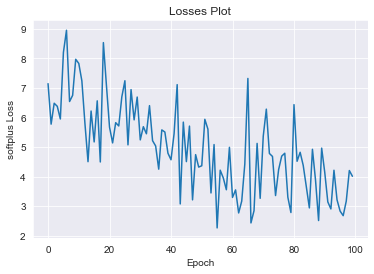

In [28]:
model = result.model
result.plot_losses()

In [29]:
# create a rank based evaluator object for test set performance metrics
evaluator = RankBasedEvaluator()
metrics = evaluator.evaluate(result.model, testing.mapped_triples,
                             additional_filter_triples = [training.mapped_triples])

Evaluating on cpu:   0%|          | 0.00/6.00 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds


In [30]:
## fake data so no good performance
print(f"Hits@1: {metrics.get_metric('tail.hits@1')}")
print(f"Hits@3: {metrics.get_metric('tail.hits@3')}")
print(f"Hits@5: {metrics.get_metric('tail.hits@5')}")
print(f"Hits@10: {metrics.get_metric('tail.hits@10')}")
print(f"Mean reciprocal rank: {metrics.get_metric('tail.mean_reciprocal_rank')}")

Hits@1: 0.16666666666666666
Hits@3: 0.3333333333333333
Hits@5: 0.3333333333333333
Hits@10: 0.3333333333333333
Mean reciprocal rank: 0.2647702693939209


In [ ]:
# cold start recommendation example

In [37]:
from pykeen.datasets.inductive.ilp_teru import InductiveFB15k237
from pykeen.models.inductive import InductiveNodePieceGNN
from pykeen.training import SLCWATrainingLoop
from pykeen.evaluation.rank_based_evaluator import SampledRankBasedEvaluator
from pykeen.stoppers import EarlyStopper
from pykeen.losses import NSSALoss

from torch.optim import Adam

In [32]:
dataset = InductiveFB15k237(version="v1", create_inverse_triples=True)

In [35]:
dataset.transductive_training.triples

array([['/m/011hq1',
        '/base/aareas/schema/administrative_area/administrative_parent',
        '/m/03rk0'],
       ['/m/011s9r', '/people/person/gender', '/m/05zppz'],
       ['/m/011vx3', '/people/person/gender', '/m/05zppz'],
       ...,
       ['/m/0yx74', '/location/location/time_zones', '/m/02fqwt'],
       ['/m/0z07',
        '/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/service_language',
        '/m/02h40lc'],
       ['/m/0z07', '/business/business_operation/industry', '/m/0vg8']],
      dtype='<U146')

In [38]:
model = InductiveNodePieceGNN(
    triples_factory=dataset.transductive_training,  # training factory, will be also used for a GNN
    inference_factory=dataset.inductive_inference,  # inference factory, will be used for a GNN
    num_tokens=12,  # length of a node hash - how many unique relations per node will be used
    aggregation="mlp",  # aggregation function, defaults to an MLP, can be any PyTorch function
    loss=NSSALoss(margin=15),  # dummy loss
    random_seed=42,
    gnn_encoder=None,  # defaults to a 2-layer CompGCN with DistMult composition function
)

sampling:   0%|          | 0.00/1.59k [00:00<?, ?it/s]

sampling:   0%|          | 0.00/1.09k [00:00<?, ?it/s]

In [39]:
optimizer = Adam(params=model.parameters(), lr=0.0005)


In [41]:
training_loop = SLCWATrainingLoop(
    triples_factory=dataset.transductive_training,  # training triples
    model=model,
    optimizer=optimizer,
    negative_sampler_kwargs=dict(num_negs_per_pos=32),
    mode="training",   # necessary to specify for the inductive mode - training has its own set of nodes
)

valid_evaluator = SampledRankBasedEvaluator(
    mode="validation",   # necessary to specify for the inductive mode - this will use inference nodes
    evaluation_factory=dataset.inductive_validation,  # validation triples to predict
    additional_filter_triples=dataset.inductive_inference.mapped_triples,   # filter out true inference triples
)

test_evaluator = SampledRankBasedEvaluator(
    mode="testing",   # necessary to specify for the inductive mode - this will use inference nodes
    evaluation_factory=dataset.inductive_testing,  # test triples to predict
    additional_filter_triples=dataset.inductive_inference.mapped_triples,   # filter out true inference triples
)

early_stopper = EarlyStopper(
    model=model,
    training_triples_factory=dataset.inductive_inference,
    evaluation_triples_factory=dataset.inductive_validation,
    frequency=1,
    patience=100000,  # for test reasons, turn it off
    result_tracker=None,
    evaluation_batch_size=256,
    evaluator=valid_evaluator,
)


INFO:pykeen.evaluation.rank_based_evaluator:Sampling 50 negatives for each of the 206 evaluation triples.
INFO:pykeen.evaluation.rank_based_evaluator:Sampling 50 negatives for each of the 205 evaluation triples.
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt


In [42]:
# Training starts here
training_loop.train(
    triples_factory=dataset.transductive_training,
    stopper=early_stopper,
    num_epochs=100,
)


INFO:pykeen.training.training_loop:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value '{batch_size}'


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/33 (3.03%) batches).


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.10s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 1: 0.18932038834951456. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 1.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 6: 0.19902912621359223. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 6.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 7: 0.2621359223300971. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 7.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 8: 0.2815533980582524. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 8.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 9: 0.33980582524271846. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 9.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.35436893203883496. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 11: 0.3762135922330097. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 11.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 12: 0.3907766990291262. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 12.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 14: 0.4053398058252427. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 14.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 16: 0.42961165048543687. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 16.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 17: 0.441747572815534. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 17.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 18: 0.4563106796116505. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 18.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 23: 0.46116504854368934. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 23.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 24: 0.4684466019417476. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 24.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 26: 0.5048543689320388. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 26.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 34: 0.5194174757281553. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 34.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.5388349514563107. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 41: 0.5509708737864077. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 41.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 44: 0.5606796116504854. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 44.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.11s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.5679611650485437. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 46: 0.5800970873786407. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 46.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 47: 0.5898058252427184. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 47.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 48: 0.6067961165048543. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 48.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 61: 0.6140776699029126. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 61.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 62: 0.633495145631068. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 62.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 66: 0.6407766990291263. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 66.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.10s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 81: 0.6529126213592233. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 81.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.11s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 99: 0.6601941747572816. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 99.


Training batches on cpu:   0%|          | 0/33 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/206 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.10s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 100: 0.6723300970873787. Saved model weights to C:\Users\vijmr\.data\pykeen\checkpoints\best-model-weights-ebf6498b-f8e3-430d-898a-6899ab692ad9.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 100.


[7.870372121984309,
 7.308671344410289,
 6.88071126648874,
 6.435156302018599,
 5.865490609949285,
 5.116447853319572,
 4.207489931222164,
 3.4250109412453393,
 2.8831415393135766,
 2.508646834980358,
 2.2250618428894966,
 2.0223249233130254,
 1.8993269963697954,
 1.7467118935151533,
 1.646933335246462,
 1.5223496357599895,
 1.4348484169353137,
 1.3660299759922605,
 1.2875867341503953,
 1.241566370834004,
 1.1843608238480308,
 1.1363937800580806,
 1.0930758732737917,
 1.0829928607651682,
 1.0441360166578582,
 0.9793007175127665,
 0.9556017734787681,
 0.9540261210817279,
 0.9012408112034653,
 0.9201922868237351,
 0.8721858263015747,
 0.8678686257564661,
 0.8505381797299241,
 0.8360950982931888,
 0.8178684603084218,
 0.7859197873057742,
 0.7809722875103806,
 0.770326478914781,
 0.7553353634747592,
 0.7402102658242891,
 0.7245917139631329,
 0.7240573510979161,
 0.7255683487111871,
 0.7050329013304277,
 0.7040446256146287,
 0.6949602564175924,
 0.7031035603898944,
 0.6718551877773169,
 0.6

In [43]:
# Test evaluation
result = test_evaluator.evaluate(
    model=model,
    mapped_triples=dataset.inductive_testing.mapped_triples,
    additional_filter_triples=dataset.inductive_inference.mapped_triples,
    batch_size=256,
)

# print final results
print(result.to_flat_dict())

Evaluating on cpu:   0%|          | 0.00/205 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


{'head.optimistic.z_geometric_mean_rank': 9.988701203800643, 'tail.optimistic.z_geometric_mean_rank': 11.44180168804533, 'both.optimistic.z_geometric_mean_rank': 15.198312921901863, 'head.realistic.z_geometric_mean_rank': 9.987509355272877, 'tail.realistic.z_geometric_mean_rank': 11.441493896992526, 'both.realistic.z_geometric_mean_rank': 15.1973261728305, 'head.pessimistic.z_geometric_mean_rank': 9.98634196549743, 'tail.pessimistic.z_geometric_mean_rank': 11.441189642920182, 'both.pessimistic.z_geometric_mean_rank': 15.196356851864415, 'head.optimistic.adjusted_geometric_mean_rank_index': 0.6463596583926133, 'tail.optimistic.adjusted_geometric_mean_rank_index': 0.7403884528718363, 'both.optimistic.adjusted_geometric_mean_rank_index': 0.696158750583087, 'head.realistic.adjusted_geometric_mean_rank_index': 0.6462825349717056, 'tail.realistic.adjusted_geometric_mean_rank_index': 0.7403685359961898, 'both.realistic.adjusted_geometric_mean_rank_index': 0.6961135525401075, 'head.pessimistic

In [45]:
## fake data so no good performance
print(f"Hits@1: {result.get_metric('tail.hits@1')}")
print(f"Hits@3: {result.get_metric('tail.hits@3')}")
print(f"Hits@5: {result.get_metric('tail.hits@5')}")
print(f"Hits@10: {result.get_metric('tail.hits@10')}")
print(f"Mean reciprocal rank: {result.get_metric('tail.mean_reciprocal_rank')}")

Hits@1: 0.22439024390243903
Hits@3: 0.375609756097561
Hits@5: 0.4634146341463415
Hits@10: 0.6292682926829268
Mean reciprocal rank: 0.3495823185618331
